In [17]:
import os
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import metrics
import itertools
import metric_functions as mf

%matplotlib inline


In [2]:
train_folder = os.path.join('train')
train_pneum = os.path.join(train_folder, 'PNEUMONIA')
train_norm = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join('test')
test_pneum = os.path.join(test_folder, 'PNEUMONIA')
test_norm = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join('val')
val_pneum = os.path.join(val_folder, 'PNEUMONIA')
val_norm = os.path.join(val_folder, 'NORMAL')

In [3]:
print('There are', len(os.listdir(train_pneum)), 'pneumonia images in the train set')
print('There are', len(os.listdir(train_norm)), 'normal images in the train set')
print('There are', len(os.listdir(test_pneum)), 'pneumonia images in the test set')
print('There are', len(os.listdir(test_norm)), 'normal images in the test set')
print('There are', len(os.listdir(val_pneum)), 'pneumonia images in the val set')
print('There are', len(os.listdir(val_norm)), 'normal images in the val set')

There are 3108 pneumonia images in the train set
There are 1080 normal images in the train set
There are 390 pneumonia images in the test set
There are 234 normal images in the test set
There are 777 pneumonia images in the val set
There are 271 normal images in the val set


In [4]:
train_generator_128 = ImageDataGenerator(rescale=1./255,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=15,
                                          zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 4188)
test_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 624)
val_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [5]:
train_images_128, train_labels_128 = next(train_generator_128)
test_images_128, test_labels_128 = next(test_generator_128)
val_images_128, val_labels_128 = next(val_generator_128)
train_y_128 = np.reshape(train_labels_128[:,1], (4186,1))
test_y_128 = np.reshape(test_labels_128[:,1], (624,1))
val_y_128 = np.reshape(val_labels_128[:,1], (1046,1))
print ("train_images shape: " + str(train_images_128.shape))
print ("train_labels shape: " + str(train_labels_128.shape))
print ("test_images shape: " + str(test_images_128.shape))
print ("test_labels shape: " + str(test_labels_128.shape))
print ("val_images shape: " + str(val_images_128.shape))
print ("val_labels shape: " + str(val_labels_128.shape))

train_images shape: (4186, 128, 128, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 128, 128, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 128, 128, 1)
val_labels shape: (1046, 2)


In [6]:
class_labels = list(train_generator_128.class_indices.keys())

In [7]:
model_12_128_6_quad_rmsprop = models.load_model('model_12_128_6_quad_rmsprop.hdf5')

In [8]:
def generate_confusion_indices(test_y_true, test_y_pred):
    a = test_y_true.astype(int).reshape(len(test_y_true),)
    b = test_y_pred.astype(int).reshape(len(test_y_pred),)
    true_vs_pred = list(zip(a, b))
    
    x = 0                # (truth, pred)
    true_positives = []  # (1, 1)
    true_negatives = []  # (0 ,0)
    false_positives = [] # (1, 0)
    false_negatives = [] # (0, 1)
    
    for pair in true_vs_pred:
        if pair[0] == 1 and pair[1] == 1:
            true_positives.append(x)
        if pair[0] == 0 and pair[1] == 0:
            true_negatives.append(x)
        if pair[0] == 1 and pair[1] == 0:
            false_positives.append(x)
        if pair[0] == 0 and pair[1] == 1:
            false_negatives.append(x)
        x += 1
    
    print('True positives:', len(true_positives))
    print('True negatives:', len(true_negatives))
    print('False positives:', len(false_positives))
    print('False negatives:', len(false_negatives))
    
    return true_positives, true_negatives, false_positives, false_negatives
    

In [9]:
y_pred = model_12_128_6_quad_rmsprop.predict_classes(test_images_128)

In [10]:
true_positives, true_negatives, false_positives, false_negatives = generate_confusion_indices(test_y_128, y_pred)

True positives: 376
True negatives: 187
False positives: 14
False negatives: 47


# Plotting Six Images From Each Category

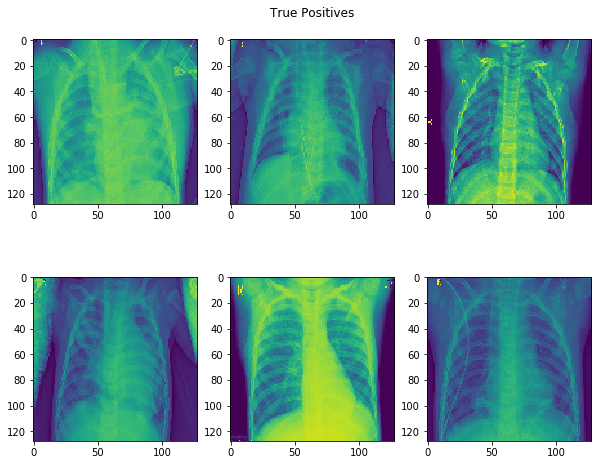

In [12]:
f = plt.figure(figsize=(10,8))
plt.title('True Positives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(val_images_128[true_positives[0]]))
ax2.imshow(array_to_img(val_images_128[true_positives[1]]))
ax3.imshow(array_to_img(val_images_128[true_positives[2]]))
ax4.imshow(array_to_img(val_images_128[true_positives[3]]))
ax5.imshow(array_to_img(val_images_128[true_positives[4]]))
ax6.imshow(array_to_img(val_images_128[true_positives[5]]))
plt.show()

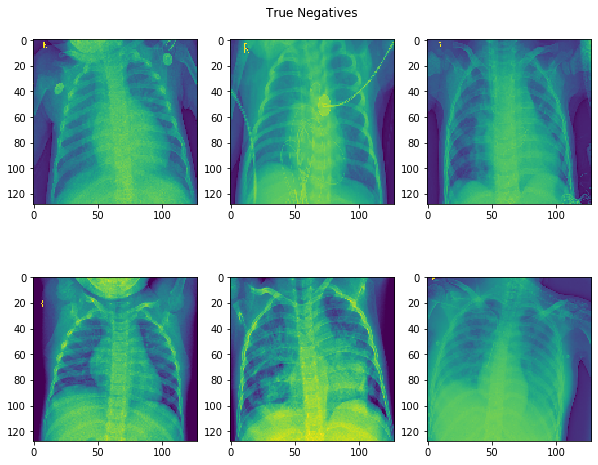

In [13]:
f = plt.figure(figsize=(10,8))
plt.title('True Negatives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(val_images_128[true_negatives[0]]))
ax2.imshow(array_to_img(val_images_128[true_negatives[1]]))
ax3.imshow(array_to_img(val_images_128[true_negatives[2]]))
ax4.imshow(array_to_img(val_images_128[true_negatives[3]]))
ax5.imshow(array_to_img(val_images_128[true_negatives[4]]))
ax6.imshow(array_to_img(val_images_128[true_negatives[5]]))
plt.show()

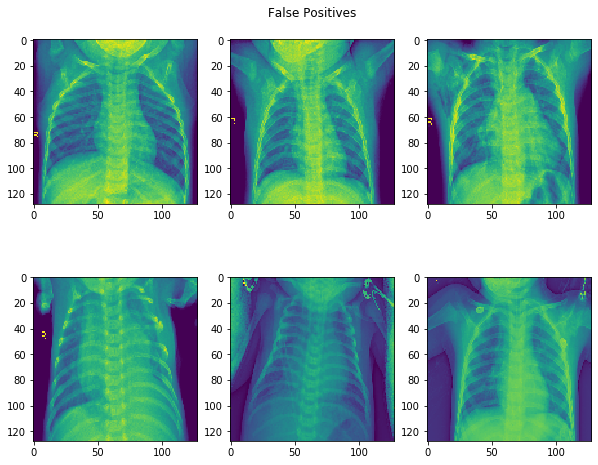

In [14]:
f = plt.figure(figsize=(10,8))
plt.title('False Positives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(val_images_128[false_positives[0]]))
ax2.imshow(array_to_img(val_images_128[false_positives[1]]))
ax3.imshow(array_to_img(val_images_128[false_positives[2]]))
ax4.imshow(array_to_img(val_images_128[false_positives[3]]))
ax5.imshow(array_to_img(val_images_128[false_positives[4]]))
ax6.imshow(array_to_img(val_images_128[false_positives[5]]))
plt.show()

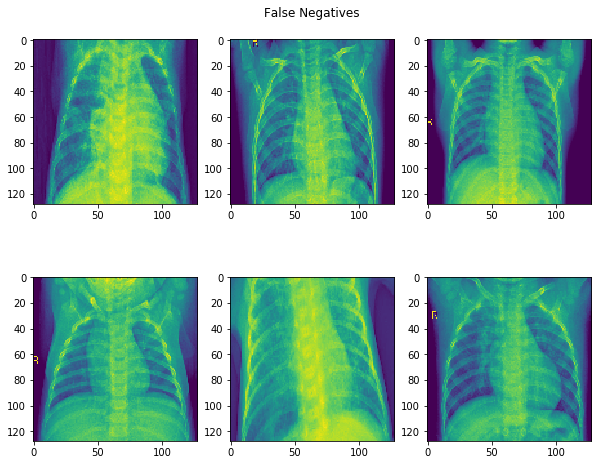

In [15]:
f = plt.figure(figsize=(10,8))
plt.title('False Negatives')
plt.axis('off')
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
ax1.imshow(array_to_img(val_images_128[false_negatives[0]]))
ax2.imshow(array_to_img(val_images_128[false_negatives[1]]))
ax3.imshow(array_to_img(val_images_128[false_negatives[2]]))
ax4.imshow(array_to_img(val_images_128[false_negatives[3]]))
ax5.imshow(array_to_img(val_images_128[false_negatives[4]]))
ax6.imshow(array_to_img(val_images_128[false_negatives[5]]))
plt.show()

# Visualizing the first activation layer

In [18]:
img_path = train_norm + '/IM-0115-0001.jpeg'


img = image.load_img(img_path, color_mode = 'grayscale', target_size=(128, 128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor /= 255.

print(img_tensor.shape)

(1, 128, 128, 1)


In [20]:
layer_outputs = [layer.output for layer in model_12_128_6_quad_rmsprop.layers[:8]]
activation_model = models.Model(inputs=model_12_128_6_quad_rmsprop.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

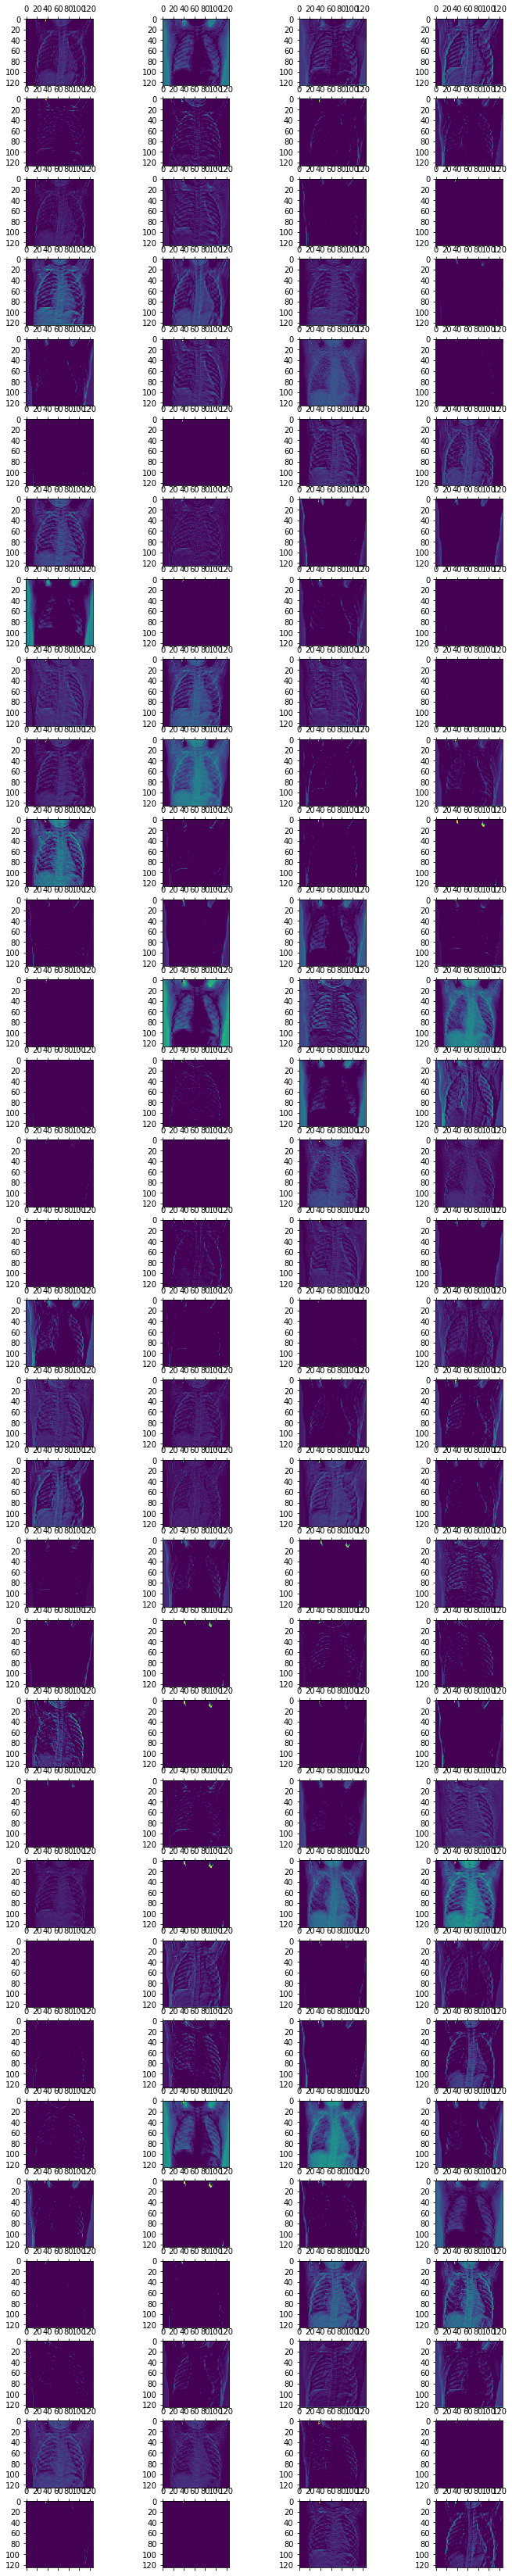

In [21]:
fig, axes = plt.subplots(32, 4, figsize=(12,60))
for i in range(128):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [9]:
# Lucy gray
# Gamora brown
# Snick black